In [1]:
import pandas as pd
import seaborn as sns
import pingouin as pg
import matplotlib.pyplot as plt
import scipy.stats

import requests
from urllib.parse import urlencode

In [2]:
sns.set(
    font_scale=1.5,
    style="whitegrid",
    rc={'figure.figsize':(12,8)}
        )

Вы работаете в приложении по доставке готовых продуктов. К вам пришел коллега с результатами двух тестов:  
В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные

Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый
Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия. Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

### Описание данных
5_task_1:  
id – id клиента в эксперименте  
group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)  
events – сколько блюд суммарно было заказано за период  

5_task_2:  
id – id клиента в эксперименте  
segment – сегмент (high/low)  
group – вид кнопки (control – старая версия, test – новая версия)  
events – сколько блюд суммарно было заказано за период  

In [3]:
# Ссылка с данными эксперимента с фотографиями блюд
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/Lj5WClBbCt3fyw'

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

In [4]:
# Загружаем данные первого эксперимента
df1 = pd.read_csv(download_url)

In [5]:
# Ссылка с данными эксперимента с кнопкой заказа
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/Vnlvg9uOrMVKhw'

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

In [6]:
# Загружаем данные второго эксперимента
df2 = pd.read_csv(download_url)

### Первый эксперимент

In [7]:
df1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


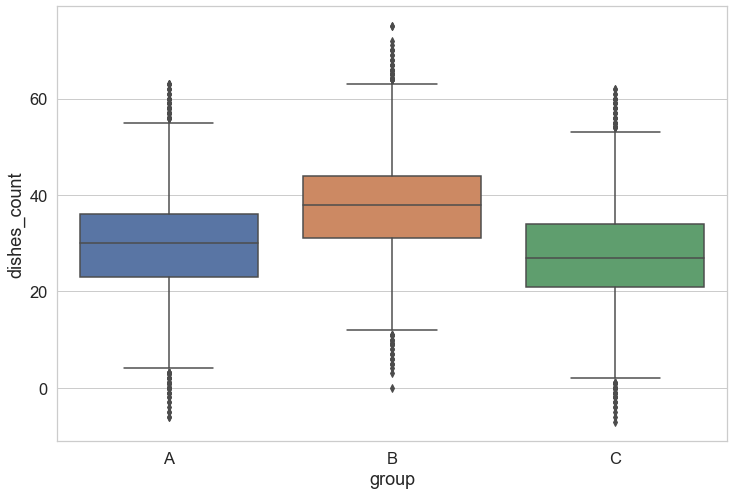

In [8]:
# Посмотрим как распределены данные трех групп эксперимента с фотографиями блюд
sns.boxplot(data=df1, x='group', y='events')
plt.ylabel('dishes_count')
plt.show()

На первый взгляд группы с прямоугольными фотографиями практические не отличаются(А и С), у группы с квадратными фотографиями количество заказанных блюд побольше

Для статистического сравнения трех групп мы воспользуемся однофакторным дисперсионным анализом ANOVA. Для начала проверим гомогенность дисперсий внутри групп с помощью теста Левена

In [9]:
pg.homoscedasticity(data=df1, dv='events', group='group')

,W,pval,equal_var
levene,2.26226,0.104133,True


Проверку на однородность дисперсий наши группы прошли. Также убедимся, что данные распределены нормально, применив тест Шапиро-Уилка. Возьмем по 1000 испытуемых с каждой группы, так как тест плохо работает на больших данных

In [10]:
scipy.stats.shapiro(df1[df1["group"] == 'A']['events'].sample(1000))

ShapiroResult(statistic=0.998104453086853, pvalue=0.3291724920272827)

In [11]:
scipy.stats.shapiro(df1[df1["group"] == 'B']['events'].sample(1000))

ShapiroResult(statistic=0.9980069398880005, pvalue=0.28554537892341614)

In [12]:
scipy.stats.shapiro(df1[df1["group"] == 'C']['events'].sample(1000))

ShapiroResult(statistic=0.9983478784561157, pvalue=0.4594624936580658)

У всех наших групп нормальное распределение. Теперь мы убедились, что сможем применить дисперсионный анализ
Нулевая гипотеза(Н0) - средние значения всех трех групп равны
Альтернативная гипотеза(Н1) - есть как минимум 2 группы средние значения которых отличаются друг от друга

In [13]:
pg.anova(data=df1, dv='events', between='group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


p-value оказался меньше 0.05, что позволяет нам отклонить нелевую гипотезу и принять альтернативную. Но с помощью этого критерия мы убедились, что есть значимые различия между группами, но мы не знаем в каких именно граппах оно есть. Для определения мы можем воспользоваться критерием Тьюки, который попарно сравнит каждую группу

In [14]:
pg.pairwise_tukey(data=df1, dv='events', between='group')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.0,-0.806377
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.0,0.211712
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.0,1.018089


Попарное сравнение групп с помщью теста Тьюки говорит о значимом отличии всех трех групп между собой. Так как у группы В наша метрика значимо выше, чем у остальных групп, рекомендуется ее ввести для всех пользователей

------------------------------------------------------------------------------------------------------
### Второй эксперимент

Во втором эксперименте требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента. В данном случае для проверки нам пригодится многофакторный дисперсионный анализ

In [15]:
df2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [16]:
# Выделим контрольную группу в отдельную таблицу
control = df2[df2['group'] == 'control']

In [17]:
# Выделим тестовую группу в отдельную таблицу
test = df2[df2['group'] == 'test']

C:\Users\Vlad_Admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


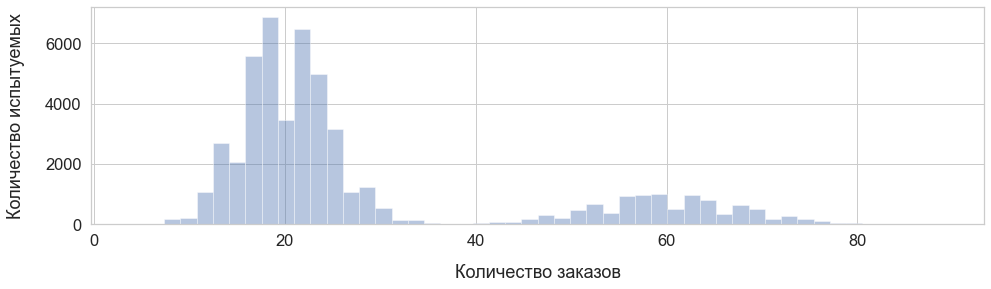

In [18]:
# Строим график распределения количества заказов у контрольной группы
plt.figure(figsize=(16, 4))
sns.distplot(control[['events']], kde=False)
plt.xlabel('Количество заказов', labelpad=15)
plt.ylabel('Количество испытуемых', labelpad=20)
plt.show()

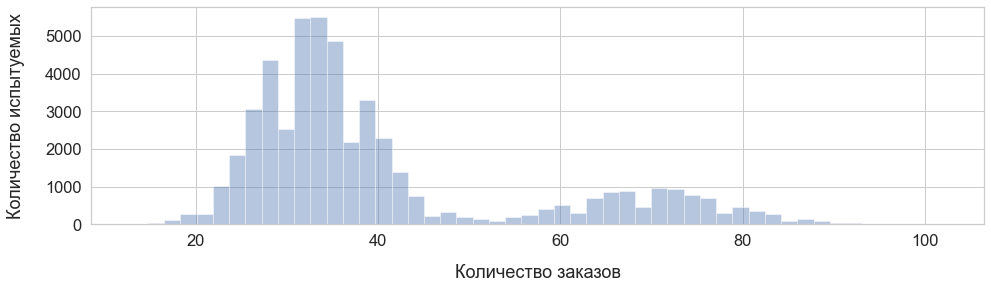

In [19]:
# Строим график распределения количества заказов у тестовой группы
plt.figure(figsize=(16, 4))
sns.distplot(test[['events']], kde=False)
plt.xlabel('Количество заказов', labelpad=15)
plt.ylabel('Количество испытуемых', labelpad=20)
plt.show()

Проведем многофакторный дисперсионный анализ, где сравниваются средние значения групп между экспериментальными группами, между сегментами и их взаимодействию:

In [20]:
pg.anova(df2, dv='events', between=['group', 'segment'])

,Source,SS,DF,MS,F,p-unc,np2
0,group,3.837195e+06,1.0,3.837195e+06,112031.864119,0.000000e+00,0.528383
1,segment,2.362480e+07,1.0,2.362480e+07,689756.377485,0.000000e+00,0.873383
2,group * segment,3.664244e+04,1.0,3.664244e+04,1069.823273,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


По результатам многофакторного дисперсионного анализа мы можем сказать, что средние значения между вышеперечисленными группами значимо отличаются. Посмотрим между какими именно группами есть статистически значимые различия с помощью критерия попарного сравнения Тьюки

In [21]:
# Создаем отдельный столбец, который определяет к какой группе относится испытуемый
df2['combination'] = df2['group'] + ' / ' + df2['segment']

In [22]:
pg.pairwise_tukey(data=df2, dv='events', between=['combination'])

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,control / high,control / low,59.970800,20.031575,39.939225,0.065432,610.391461,0.0,6.824282
1,control / high,test / high,59.970800,69.938500,-9.967700,0.082766,-120.432523,0.0,-1.703109
2,control / high,test / low,59.970800,33.025925,26.944875,0.065432,411.798717,0.0,4.603981
3,control / low,test / high,20.031575,69.938500,-49.906925,0.065432,-762.727892,0.0,-8.527429
4,control / low,test / low,20.031575,33.025925,-12.994350,0.041383,-314.002699,0.0,-2.220314
5,test / high,test / low,69.938500,33.025925,36.912575,0.065432,564.135148,0.0,6.307128


Тест Тьюки показывает знамимые различия между всеми группами попарно!

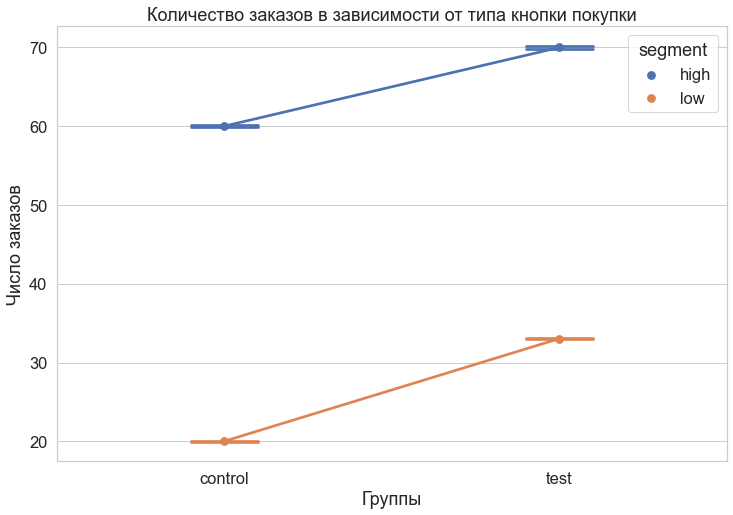

In [24]:
# Построим график для изучения изменения количества заказов между группами
sns.pointplot(data=df2, x='group', y='events', hue='segment', capsize = .2, order=['control', 'test'])
plt.title('Количество заказов в зависимости от типа кнопки покупки')
plt.xlabel('Группы')
plt.ylabel('Число заказов')
plt.show()

Судя по полученным данным и этому графику, мы можем сказать об увеличении количества заказов у тестовой группы с новой кнопкой, увеличение коснулась как низкий, так и высокий сегмент. Рекомендуется ввести изменения всем пользователям